# Data Description

## TUAB
----
* labels legend:
	1. label 0 = abnormal
	2. label 1 = normal
* Channel set: A1, A2, C3, C4, CZ, F3, F4, F7, F8, FP1, FP2, FZ, O1, O2, P3, P4, PZ, T3, T4, T5, T6  
* Sample frequency: 250 Hz


## TUAR
-----
* labels legend:
	1. label 0 = artifact
	2. label 1 = clean
* Channel set: A1, A2, C3, C4, CZ, F3, F4, F7, F8, FP1, FP2, FZ, O1, O2, P3, P4, PZ, T1, T2, T3, T4, T5, T6
* Sample frequency: 250 Hz

* Channels to be removed before merging: T1, T2

In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Feature Selection and Pre-processing Imports
from sklearn.preprocessing import StandardScaler

#Model Selection  and Classifier Imports
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, GridSearchCV, LeaveOneOut
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier

#Metrics Imports
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, RocCurveDisplay
from sklearn.metrics import matthews_corrcoef, classification_report, roc_curve, auc, recall_score, f1_score, roc_auc_score

#Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import pairplot as pplot

#Data Augmentation Library
from imblearn.over_sampling import SMOTE

## Helper Function to load the data

In [38]:
def read_from_h5(path):
    f = h5py.File(path, 'r')
    data = np.array(f['dataset'])
    label = np.array(f['label'])
    ID = np.array([i.decode('utf_8') for i in np.array(f['ID'])])
    
    return data, label, ID


data_ar, label_ar, ID_ar = read_from_h5('TUAR.hdf5')  # artifact(0) + clean(1) signal
data_ab, label_ab, ID_ab = read_from_h5('TUAB.hdf5')  # abnormal(0) + normal(1) signal


## Making sense of Data

* data - N-Dimensional numpy array with shape (200,500,23/21) , last dimension represents the no. of channels.
* label - 200 labels for the samples
* ID - ID of the samples

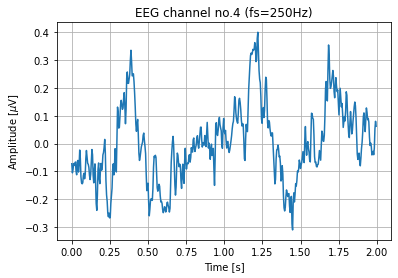

In [3]:
fig = plt.figure
time = np.arange(0,2,1/250)
plt.plot(time, data_ar[0,:,4])
plt.tight_layout
plt.ylabel('Amplitude [$\mu$V]')
plt.title('EEG channel no.4 (fs=250Hz)')
plt.xlabel('Time [s]')
plt.grid(True)
plt.show()

In [4]:
# Shape of the two datasets

print('Shape of the two datasets are TUAB: {} , TUAR: {}'.format(data_ab.shape , data_ar.shape))

Shape of the two datasets are TUAB: (200, 500, 21) , TUAR: (200, 500, 23)


In [5]:
# Removing uncommon channels from TUAR dataset

data_ar = np.delete(data_ar,[17,18],axis = 2)
print(data_ar.shape)

# X_train_reshaped = np.reshape(new_ar, (200, 500 * 21))

(200, 500, 21)


In [6]:
# unique labels of 0's and 1's
l,c = np.unique(label_ab, return_counts=True)
l,c

(array([0, 1]), array([100, 100]))

In [7]:
# Creating a dataframe as a visual reference of the labels for the two datasets
label_dict = {'label_ab (abnormal + normal)': label_ab, 'label_ar (artifact + clean)': label_ar}
label_df = pd.DataFrame(data = label_dict)
label_df

,label_ab (abnormal + normal),label_ar (artifact + clean)
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
195,1,1
196,1,1
197,1,1
198,1,1


In [8]:
# clean + normal  = 1, abnormal = 2, artifact = 3

label_df['label_ab (abnormal + normal)'] = label_df['label_ab (abnormal + normal)'].where(label_df['label_ab (abnormal + normal)'] > 0, 2)
label_df['label_ar (artifact + clean)'] = label_df['label_ar (artifact + clean)'].where(label_df['label_ar (artifact + clean)']>0,3)
label_df

,label_ab (abnormal + normal),label_ar (artifact + clean)
0,2,3
1,2,3
2,2,3
3,2,3
4,2,3
...,...,...
195,1,1
196,1,1
197,1,1
198,1,1


In [9]:
# Data for the first pipeline
data_pip1 = np.vstack((data_ab,data_ar))
# print(data_pip1)
print(data_pip1.shape)

(400, 500, 21)


In [10]:
# labels for the first pipeline

label_org = label_df['label_ab (abnormal + normal)'].to_numpy()
label_org = np.append(label_org,label_df['label_ar (artifact + clean)'].to_numpy())
print(label_org)

label_track = pd.DataFrame(label_org, columns=['Original_labels'])
print(label_track)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
     Original_labels
0                  2
1                  2
2                  2
3                  2
4                  2
..               ...
395                1
396                1

In [11]:
data_pip1 = data_pip1.reshape((400,500*21)) # For each sample/person combine the data from the 21 channels into a single vector
data_pip1.shape

(400, 10500)

In [22]:
# clean + normal  = 1, abnormal = 2, artifact = 3 -> Original relabeling
label_first_classification = label_org.copy()
label_first_classification[(label_first_classification == 1) | (label_first_classification == 2)] = 0 # We relabel class 1 and 2 in a single class 0(Clean+normal+abnormal = Non-Artifact) and class 3 into class 1(Artifactual)
label_first_classification[label_first_classification !=0] = 1

print(label_first_classification)
label_track['Labels_pip1_classifier1'] = label_first_classification

print(label_track, label_track.shape)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
     Original_labels  Labels_pip1_classifier1
0                  2                        0
1                  2                        0
2                  2                        0
3   

In [13]:
# # Split the data into train and test sets such that the ratio of the classes in the train and test sets are the same

# sss = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=0)


# for train_index, test_index in sss.split(data_pip1, label_first_classification):
#     X_train = data_pip1[train_index]
#     X_test = data_pip1[test_index]
#     y_train = label_first_classification[train_index]
#     y_test = label_first_classification[test_index]
    
# trlabels, trfreqs = np.unique(y_train,return_counts=True)
# tslabels, tsfreqs = np.unique(y_test,return_counts=True)

# print('Train Labels:',trlabels,'-> Corresponding Frequencies',trfreqs)
# print('Test Labels:',tslabels,'-> Corresponding Frequencies',tsfreqs)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(data_pip1, label_first_classification, test_size=0.33, random_state=42)

trlabels, trfreqs = np.unique(y_train,return_counts=True)
tslabels, tsfreqs = np.unique(y_test,return_counts=True)

print('Train Labels:',trlabels,'-> Corresponding Frequencies',trfreqs)
print('Test Labels:',tslabels,'-> Corresponding Frequencies',tsfreqs)

Train Labels: [0 1] -> Corresponding Frequencies [199  69]
Test Labels: [0 1] -> Corresponding Frequencies [101  31]


In [27]:
clf = RandomForestClassifier(n_estimators=10,max_depth=5, random_state=0)
clf.fit(X_train,y_train)

RandomForestClassifier(max_depth=5, n_estimators=10, random_state=0)

In [28]:
clf.score(X_train,y_train)

0.9440298507462687

In [29]:
y_predict = clf.predict(X_test)
y_train_predict = clf.predict(X_train)

In [30]:
clf.score(X_test,y_test)

0.7727272727272727

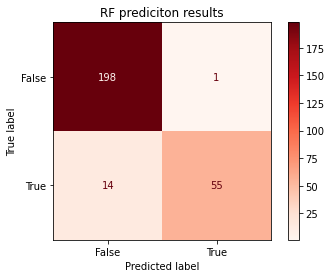

Model ROC-AUC: 0.8960381618236108
Accuracy score for test set: 0.9440298507462687


In [32]:
#Confusion Matrix of the predictions

cm = metrics.confusion_matrix(y_train,y_train_predict)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix = cm,
    display_labels = [False, True],
)
cm_display = cm_display.plot(cmap=plt.cm.Reds,values_format='g')
plt.grid(False)
plt.title('RF prediciton results')
plt.show()


print ('Model ROC-AUC:',roc_auc_score(y_train,y_train_predict))
print('Accuracy score for test set:',accuracy_score(y_train,y_train_predict))
# print('Matthew Correlation Coeff:',matthews_corrcoef(y_test, y_predict))